In [1]:
import numpy as np
import xml.etree.ElementTree as ET
from pathlib import Path

r = Path('/home/rens/hpc/PREMIUM histopathology/data_annotations/isala/annotations')

file = list(r.iterdir())[1]
with open(file, 'r') as f:
    xml_file = ET.parse(f)

rois = []
for annotation in xml_file.getroot()[0]:
    roi = []
    for coordinate in annotation[0]:
        roi.append([coordinate.attrib['X'], coordinate.attrib['Y']])
    rois.append(np.array(roi).astype(float).astype(int))


In [2]:
import cv2

mask = np.zeros((50688,84480))
cv2.fillPoly(mask, rois,1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

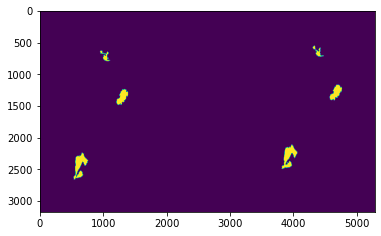

(3168, 5280)

In [13]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

reduced_mask = zoom(mask, 1/16, mode='nearest', order=0)

plt.imshow(reduced_mask)
plt.show()
reduced_mask.shape

In [9]:
import openslide

slide_r = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis')

slide = openslide.OpenSlide(str(slide_r / (file.stem + '.ndpi')))

In [11]:
img = np.array(slide.read_region((0,0), 4, slide.level_dimensions[4]).convert('RGB'))

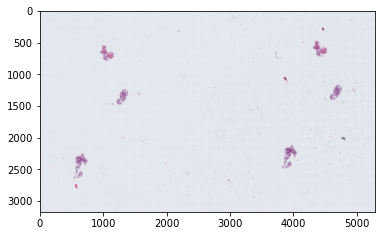

(3168, 5280, 3)

In [12]:
plt.imshow(img)
plt.show()
img.shape

In [2]:
import sys
import cv2
import torch
import geojson
import openslide
import numpy as np
import xml.etree.ElementTree as ET
from pytorch_lightning import LightningModule
from monai.transforms import Lambdad, Compose, ToTensord
from monai.data import CacheDataset
from torch.utils.data import DataLoader
from util import format_output, output2annotations, normalize_staining
from pytorch_lightning import Trainer
from pathlib import Path

sys.path.insert(1, '/home/rens/repos/hover_net')

from models.hovernet.net_desc import HoVerNet


class Processor(LightningModule):
    def __init__(self, slide_path, annotation_path):
        super().__init__()

        # setup hovernet
        self.net = HoVerNet(nr_types=6,mode='fast')
        ckpt = torch.load('/home/rens/repos/premium_pathology/weights/hovernet_fast_pannuke_type_tf2pytorch.tar')
        self.net.load_state_dict(ckpt['desc'], strict=True)

        # open slide
        self.slide = openslide.OpenSlide(str(slide_path))
        dimensions = np.array(self.slide.level_dimensions)

        # load annotation
        with open(annotation_path, 'r') as f:
            xml_file = ET.parse(f)

        # extract polygons from annotation
        self.rois = []
        for annotation in xml_file.getroot()[0]:
            roi = []
            for coordinate in annotation[0]:
                roi.append([coordinate.attrib['X'], coordinate.attrib['Y']])
            self.rois.append(np.array(roi).astype(float).astype(int))

        # create mask from annotation
        self.mask = np.zeros(np.flip(self.slide.dimensions))
        cv2.fillPoly(self.mask, self.rois, 1)
        self.mask = self.mask.astype(bool)

        # create and filter list of origins which will be inferenced
        xx = np.arange(0,self.slide.dimensions[0], 164)[:-1]
        yy = np.arange(0,self.slide.dimensions[1], 164)[:-1]

        self.origins = np.array([(x,y) for y in yy for x in xx])
        filtered_origins = self.origins[[self.mask[y,x] for x,y in self.origins]]

        # self.input is the input to the dataset
        self.input = [{'origin':origin, 'image':origin} for origin in filtered_origins]

        # output classes
        self.classes = {
            0 : "nolabe",
            1 : "neopla",
            2 : "inflam",
            3 : "connec",
            4 : "necros",
            5 : "no-neo",
        }

        # list for storing outputted annotations
        self.output = []

    def forward(self, x):
        return self.net(x)

    def test_dataloader(self):
        ds = CacheDataset(
            self.input,
            transform=Compose([
                Lambdad(
                    keys='image', 
                    func=lambda x: np.array(processor.slide.read_region(
                        (x[0] - 46, x[1] - 46),
                        0,
                        (256,256)
                    ).convert('RGB'))
                ),
                Lambdad(
                    keys='image',
                    func=lambda x: normalize_staining(x)[0]
                ),
                Lambdad(
                    keys='image', 
                    func = lambda x: x.transpose(2,0,1)
                ),
                ToTensord(keys='image')
            ]),
            cache_rate=0.01
        )

        return DataLoader(ds, batch_size=16)

    def test_step(self, batch, batch_ix):
        origins, images, _ = batch.values()
        output = self.net(images)

        for k in output.keys():
            output[k] = output[k].detach().cpu()

        formatted_output = format_output(output)
        annotations = [output2annotations(pred) for pred in formatted_output]
        
        for origin, annotation in zip(origins, annotations):
            for instance in annotation.values():
                dict_data = {}

                cc = (origin.cpu().numpy() + instance['contour']).tolist()
                cc.append(cc[0])

                dict_data["type"]="Feature"
                dict_data["id"]="PathCellObject"
                dict_data["geometry"]={
                    "type":"Polygon",
                    "coordinates":[cc]
                }
                dict_data["properties"]={
                    "isLocked":"false",
                    "measurements":[],
                    "classification": {
                        "name": self.classes[instance['type']]
                    }
                }

                self.output.append(dict_data)

    def save(self, save_path):
        with open(save_path, 'w') as file:
            geojson.dump(self.output, file)


slide = '/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis/PREM-IS-001_d8910ad17c I1 HE1 - 2022-03-24 19.55.56.ndpi'
annotation = '/home/rens/hpc/PREMIUM histopathology/data_annotations/isala/annotations/PREM-IS-001_d8910ad17c I1 HE1 - 2022-03-24 19.55.56.xml'

processor = Processor(slide, annotation)

trainer = Trainer(gpus=1)
trainer.test(processor)
save_path = '/home/rens/hpc/rens/output/only_on_masks/PREM-IS-001_d8910ad17c I1 HE1 - 2022-03-24 19.55.56.json'
processor.save(save_path)
# slide_dir = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis')
# output_dir = Path('/home/rens/hpc/rens/output/hovernet_re_output_normalized')

# for file in list(slide_dir.iterdir()):
#     print(file)


#     processor = Processor(
#         file
#     )

#     trainer = Trainer(gpus=1)
#     trainer.test(processor)

#     save_path = output_dir / (file.stem + '.json')

#     processor.save(save_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading dataset: 100%|██████████| 190/190 [00:07<00:00, 27.09it/s]

Testing: 0it [00:00, ?it/s]

Testing:   1%|          | 14/1192 [00:18<30:42,  1.56s/it]

invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in multiply


Testing: 100%|██████████| 1192/1192 [38:07<00:00,  1.55s/it]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 1192/1192 [38:07<00:00,  1.92s/it]


In [53]:
processor.mask.shape

(119040, 50688)

In [ ]:
for origin in processor.input:
    
    patch = processor.slide.read_region(origin['origin'], 0, (256,256))
    plt.imshow(patch)
    plt.show()

In [70]:
processor.input[:5]

[{'origin': array([41820,  8528]), 'image': array([41820,  8528])},
 {'origin': array([41984,  8528]), 'image': array([41984,  8528])},
 {'origin': array([42148,  8528]), 'image': array([42148,  8528])},
 {'origin': array([41656,  8692]), 'image': array([41656,  8692])},
 {'origin': array([41820,  8692]), 'image': array([41820,  8692])}]

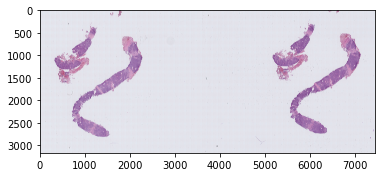

(119040, 50688)

In [68]:
patch = processor.slide.read_region((0,0), 4, processor.slide.level_dimensions[4])
plt.imshow(patch)
plt.show()
processor.slide.level_dimensions[0]

In [72]:
plt.imshow(zoom(processor.mask, 1/16))
plt.show()

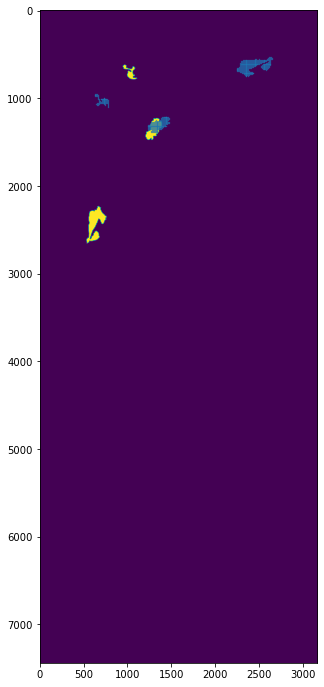

In [56]:
xx = [origin['image'][0] for origin in processor.input]
yy = [origin['image'][1] for origin in processor.input]
downsampled_mask = zoom(processor.mask, 1/16, mode='nearest', order=0)

plt.figure(figsize=(12,12))
plt.imshow(downsampled_mask)
plt.scatter(np.array(xx)/16, np.array(yy)/16, s=0.1)

plt.show()